In [62]:
images_path = "DRIVE/image"
masks_path = "DRIVE/mask"

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt



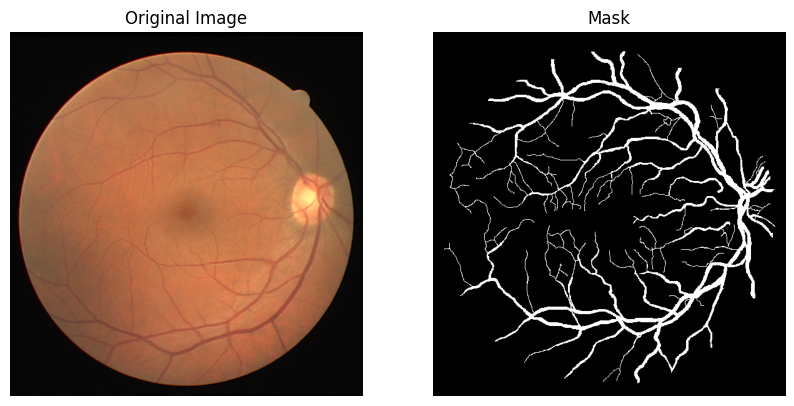

In [63]:
images = []
masks = []
for image_name,mask_name in zip(os.listdir(images_path), os.listdir(masks_path)):
    image = plt.imread(os.path.join(images_path, image_name))
    mask = plt.imread(os.path.join(masks_path, mask_name))
    mask = mask/255.0  # Normalize the mask to [0, 1] range
    # binarize the mask
    images.append(image)
    masks.append(mask)
    

# Display the first image and its corresponding mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[0])
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(masks[0], cmap="gray")
plt.title("Mask")
plt.axis("off")

plt.show()

In [ ]:
def histo_equalized_batch(imgs):
    assert (len(imgs.shape) == 4)  # 4D arrays
    assert (imgs.shape[1] == 1)  # check the channel is 1
    imgs_equalized = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        imgs_equalized[i, 0] = cv2.equalizeHist(np.array(imgs[i, 0], dtype=np.uint8))
    return imgs_equalized


# CLAHE (Contrast Limited Adaptive Histogram Equalization)
# adaptive histogram equalization is used. In this, image is divided into small blocks called "tiles" (tileSize is 8x8 by default in OpenCV). Then each of these blocks are histogram equalized as usual. So in a small area, histogram would confine to a small region (unless there is noise). If noise is there, it will be amplified. To avoid this, contrast limiting is applied. If any histogram bin is above the specified contrast limit (by default 40 in OpenCV), those pixels are clipped and distributed uniformly to other bins before applying histogram equalization. After equalization, to remove artifacts in tile borders, bilinear interpolation is applied
def clahe_equalized_batch(imgs):
    assert (len(imgs.shape) == 4)  # 4D arrays
    # assert (imgs.shape[1]==1)  #check the channel is 1
    # create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    imgs_equalized = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        imgs_equalized[i, 0] = clahe.apply(np.array(imgs[i, 0], dtype=np.uint8))
    return imgs_equalized


# ===== normalize over the dataset
def dataset_normalized_batch(imgs):
    assert (len(imgs.shape) == 4)  # 4D arrays
    # assert (imgs.shape[1]==1)  #check the channel is 1
    imgs_normalized = np.empty(imgs.shape)
    imgs_std = np.std(imgs)
    imgs_mean = np.mean(imgs)
    imgs_normalized = (imgs - imgs_mean) / imgs_std
    for i in range(imgs.shape[0]):
        imgs_normalized[i] = ((imgs_normalized[i] - np.min(imgs_normalized[i])) / (
                    np.max(imgs_normalized[i]) - np.min(imgs_normalized[i]))) * 255
    return imgs_normalized

def adjust_gamma_batch(imgs, gamma=1.0):
    assert (len(imgs.shape) == 4)  # 4D arrays
    # assert (imgs.shape[1]==1)  #check the channel is 1
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    new_imgs = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        new_imgs[i, 0] = cv2.LUT(np.array(imgs[i, 0], dtype=np.uint8), table)
    return new_imgs

def rgb2gray(rgb):
    assert (len(rgb.shape) == 4)  # 4D arrays
    assert (rgb.shape[1] == 3)
    bn_imgs = rgb[:, 1, :, :] * 0.75 + rgb[:, 2, :, :] * 0.25
    bn_imgs = np.reshape(bn_imgs, (rgb.shape[0], 1, rgb.shape[2], rgb.shape[3]))
    return bn_imgs

def preprocess_batch(data):
    assert (len(data.shape) == 4)
    assert (data.shape[1] == 3)  # Use the original images
    train_imgs = rgb2gray(data)
    # my preprocessing:
    train_imgs = dataset_normalized_batch(train_imgs)
    train_imgs = clahe_equalized_batch(train_imgs)
    train_imgs = adjust_gamma_batch(train_imgs, 1.2)
    train_imgs = train_imgs / 255.  # reduce to 0-1 range
    return train_imgs

image_list=[]
for image in images:
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    image = image.transpose(0, 3, 1, 2)           # (1, 3, H, W)
    image = preprocess_batch(image)
    image_list.append(image)



40
